# Introduction to conditional moments

In [1]:
using Plots
using Plots.PlotMeasures
using DelimitedFiles

In [2]:
t, Xₜ = let in_filename = "sample_data.txt"
    raw_data = DelimitedFiles.readdlm(in_filename)
    t = raw_data[:,1]
    xₜ = raw_data[:,2]
    t, xₜ
end;

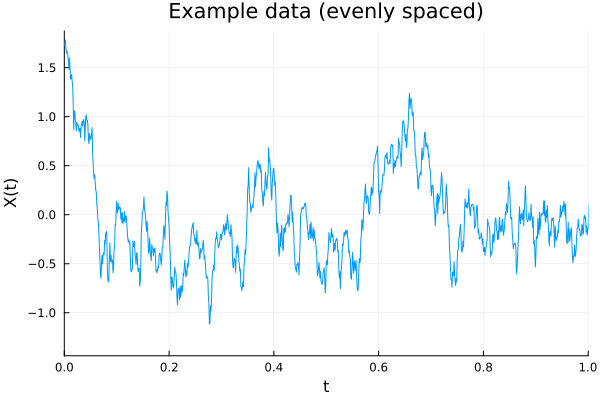

In [3]:
plot(
    t, Xₜ,
    xlim=(0,1),
    xlabel="t",ylabel="X(t)",title="Example data (evenly spaced)",label=""
)

### Aggregate statistics

We may wish to calculate some properties of the time-series.

One example is the autocorrelation:

$$ \operatorname {R}_{XX}(t_{1},t_{2})=\operatorname {E} \big[X_{t_{1}}{ {X}}_{t_{2}}\big] $$

which, assuming a wide-sense stationary process, can be written as a function of a single time-difference variable $\tau$, as

$$ {R}_{XX}(\tau )=\operatorname {E} \big[X_{t+\tau}X_{t}\big]. $$

These definitions sometimes are normalized by the variance, and/or remove the mean of the process. Assuming ergodicity gives

$$ R_{XX}(\tau )=\int _{-\infty }^{\infty }X(t+\tau ){ {X(t)}}\,{\rm {d}}t. $$

For dealing with the read data (which has a regular sampling $\Delta t$)

$$  \{X_{1},\,X_{2},\,\ldots ,\,X_{N}\} $$

the sample autocorrelation is calculated as

$$ {\hat {R}}(k)={\frac {1}{(N-k)}}\sum _{i=1}^{N-k}X_{i}X_{i+k} $$

where $\tau=k\Delta t$.

This can be implemented in `julia` code:

In [4]:
function autocorr(X,k::Int)
    ret = 0.0
    N = length(X)
    for i in 1:(N-k)
        ret += X[i] * X[i+k]
    end
    return ret
end

autocorr(X,k_vec::UnitRange) = broadcast(k->autocorr(X,k),k_vec)

autocorr (generic function with 2 methods)

In [5]:
i_lags = 1:250

acf_sample = autocorr(Xₜ,i_lags);

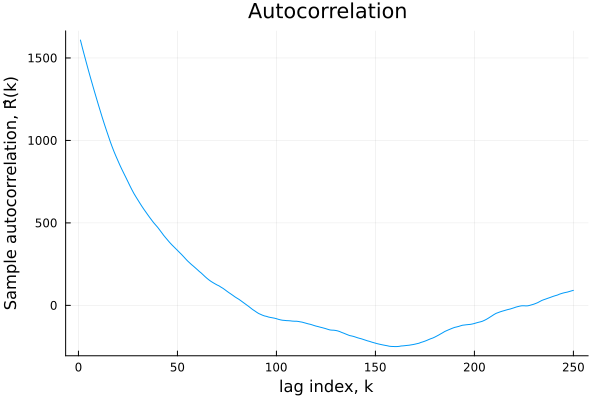

In [6]:
plot(
    i_lags,acf_sample,
    xlabel="lag index, k",ylabel="Sample autocorrelation, R̂(k)",title="Autocorrelation",label=""
)

### Another aggregate statistic

I now introduce the conditional moments

$$ {M}^{(n)}(\tau,x)=\int_{-\infty}^{\infty}(x^\prime - x)^nP(x^\prime,t+\tau | x,t
) dx^\prime. $$

They are called "conditional moments" because they are moments of the conditional transition probability distribution (Gardiner, 1985). In some literature, they are called "jump moments."

Written as an expectation operator

$$ {M}^{(n)}(\tau,x)=\operatorname {E} \left[\left(X(t+\tau) - X(t)\right)^n|X(t)=x\right] $$

Imagine evaluating at a particular $(x,\tau)$ point:

$$ x^*=-0.5, \tau^*=50\Delta t $$

Unfortunately, none of the data points fell *exactly* on $x^*=-0.5$

In [7]:
count(Xₜ .== -0.5)

0

So instead, we change the conditioning $X(t)=x$ to, for example, histogram binning

$$ {M}^{(n)}(\tau^*,x^*)=\operatorname {E} \big[\left(X(t+\tau^*) - X(t)\right)^n\big|\ x_-<X(t)<x_+\big] $$

where $x_-$ is slightly lower that $x^*$, and $x_+$ is slightly higher that $x^*$.

In [8]:
x_minus = -0.6
x_plus = -0.4

x_bin_condition(x) = (x_minus < x) & (x < x_plus)

@show count((Xₜ .> x_minus) .& (Xₜ .< x_plus))
@show count(x_bin_condition.(Xₜ))
;

count((Xₜ .> x_minus) .& (Xₜ .< x_plus)) = 996
count(x_bin_condition.(Xₜ)) = 996


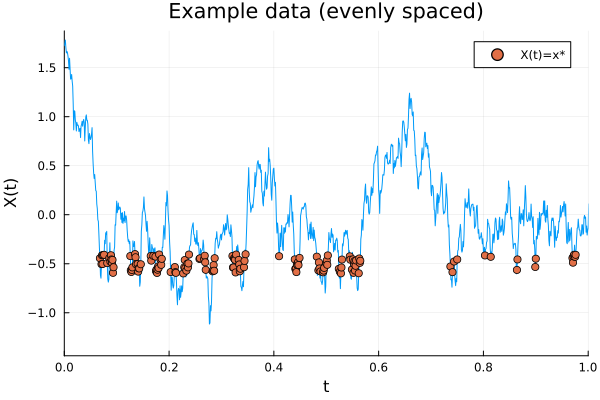

In [9]:
plot(t,Xₜ,
    xlim=(0,1),
    xlabel="t",ylabel="X(t)",title="Example data (evenly spaced)",label=""
)
scatter!(
    t[x_bin_condition.(Xₜ)],
    Xₜ[x_bin_condition.(Xₜ)],
    label="X(t)=x*"
)

But what do the points $\tau=50 \Delta t$ in the future look like?

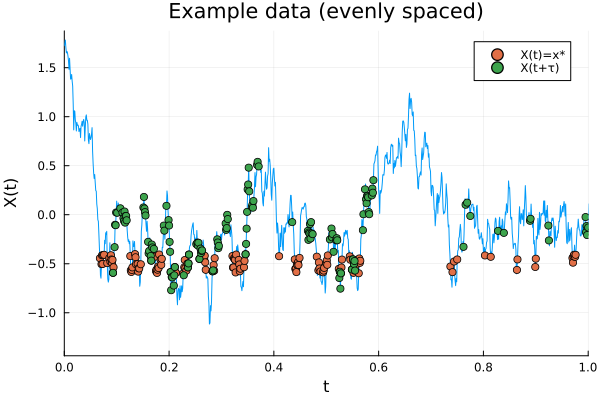

In [10]:
k = 25
i_all = findall(x_bin_condition.(Xₜ[1:end-k]))


plot(t,Xₜ,
    xlim=(0,1),
    xlabel="t",ylabel="X(t)",title="Example data (evenly spaced)",label=""
)
scatter!(
    t[i_all],
    Xₜ[i_all],
    label="X(t)=x*"
)
scatter!(
    t[i_all .+ k],
    Xₜ[i_all .+ k],
    label="X(t+τ)"
)

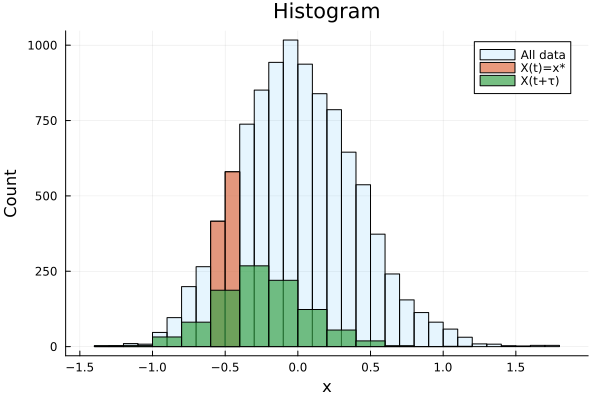

In [11]:
histogram(Xₜ, bins=50, fillalpha=0.1,label="All data")
histogram!(Xₜ[i_all], bins=2, fillalpha=0.7,label="X(t)=x*")
histogram!(Xₜ[i_all.+k], bins=20, fillalpha=0.7,label="X(t+τ)")
plot!(
    xlabel="x",ylabel="Count",title="Histogram",label=""
)

The sample condition moment is then the following expression

$$ \hat{M}^{(n)}(k,x^*)=\frac{\sum _{i=1}^{N-k}I(x_-<X_i<x_+)\left(X_{i+k} - X_i\right)^n}{\sum _{i=1}^{N-k}I(x_-<X_i<x_+)} $$

where $I(\cdot)$ is the indicator function.

This method was pioneered by Seigert et al. (1998).

The calculation can be implemented in `julia` as:

In [12]:
function conditional_moment(X,n,k::Int,x_condition)
    increment = 0.0
    count = 0
    N = length(X)
    for i in 1:(N-k)
        ind_result = x_condition(X[i])
        increment += ind_result * (X[i+k] - X[i])^n
        count += ind_result
    end
    return increment/count
end

conditional_moment(X,n,k_vec::UnitRange,x_cond) = 
    broadcast(k->conditional_moment(X,n,k,x_cond),k_vec)

conditional_moment1(X,k,x_condition) = conditional_moment(X,1,k,x_condition)
conditional_moment2(X,k,x_condition) = conditional_moment(X,2,k,x_condition)

conditional_moment2 (generic function with 1 method)

Calculate at the particular point

$$ x^*=-0.5, \tau^*=25\Delta t $$

In [13]:
m1_point = conditional_moment1(Xₜ,25,x_bin_condition)

0.23892320243118836

Plot for a range of $k$ values

In [14]:
i_lags = 1:150

conditional_moment_sample = conditional_moment1(Xₜ,i_lags,x_bin_condition);

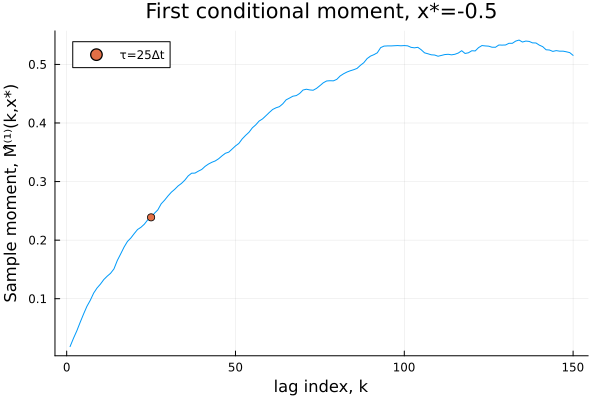

In [15]:
plot(
    i_lags,conditional_moment_sample,
    xlabel="lag index, k",ylabel="Sample moment, M̂⁽¹⁾(k,x*)",
    title="First conditional moment, x*=-0.5",label=""
)
scatter!([25],[m1_point],label="τ=25Δt")

Repeat this calculation for many $x$ conditions

In [16]:
# Boxcar kernel
struct Boxcar end
(k::Boxcar)(x) = (abs(x) < 1.0) ? 0.5 : 0.0

# Kernel based regression
function KBR_moments(X, tau_i_range, x_range, h, kernel)
    n = length(X)
    nτ = length(tau_i_range)
    nx = length(x_range)
    N = zeros(nτ,nx)
    M1 = zeros(nτ,nx)
    M2 = zeros(nτ,nx)

    hinv = inv(h)
    kernel_scaled(x) = hinv*kernel(hinv*x)

    for (i_left, X_left) in enumerate(X[1:end-1])
        for (i_ind,i_tau) in enumerate(tau_i_range)
            i_right = i_left + i_tau
            if i_right <= n
                ΔX = X[i_right] - X_left
                for (j_ind,x_eval) in enumerate(x_range)
                    K_weight = kernel_scaled(x_eval - X_left)
                    N[i_ind,j_ind] += K_weight
                    M1[i_ind,j_ind] += K_weight * ΔX
                    M2[i_ind,j_ind] += K_weight * ΔX*ΔX
                end
            end
        end
    end

    for i in 1:length(N)
        M2[i] = (M2[i] - (M1[i]*M1[i])/N[i]) / N[i]
        M1[i] = M1[i] / N[i]
    end

    return M1, M2
end

KBR_moments (generic function with 1 method)

In [17]:
x_eval_points = -0.5:0.2:0.5

kernel = Boxcar()
bandwidth = 0.1

M1, M2 = KBR_moments(Xₜ, i_lags, x_eval_points, bandwidth, kernel)
@show size(M1)

size(M1) = (150, 6)


(150, 6)

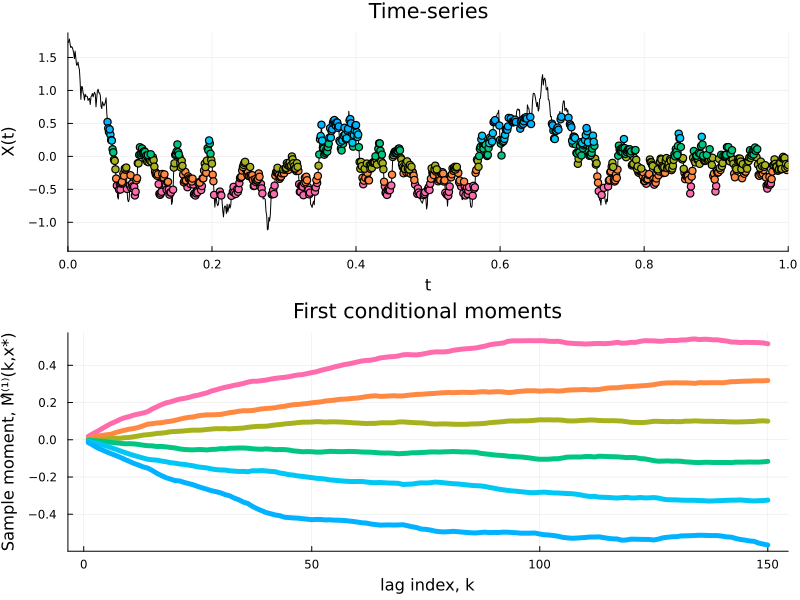

In [18]:
color_range = range(
    LCHab(70,70,0), 
    stop=LCHab(70,70,270), 
    length=size(M1,2)
)
in_bin(i) = broadcast(
    X->kernel((X-x_eval_points[i])/bandwidth) != 0.0,
    Xₜ
)

p_timeseries = plot(t,Xₜ,c=:black,xlim=(0,1),label="")
for i in 1:length(x_eval_points)
    scatter!(
        t[in_bin(i)],
        Xₜ[in_bin(i)],
        c=color_range[i],
        xlabel="t",ylabel="X(t)",title="Time-series",
        label="",
    )
end

p_moment = plot()
for i in 1:size(M1,2)
    plot!(
        i_lags,
        M1[:,i],
        linewidth=5,
        c=color_range[i],
        xlabel="lag index, k",ylabel="Sample moment, M̂⁽¹⁾(k,x*)",
        title="First conditional moments",
        label=""
    )
end

display(plot(p_timeseries,p_moment,layout=(2,1),size=(800,600)))

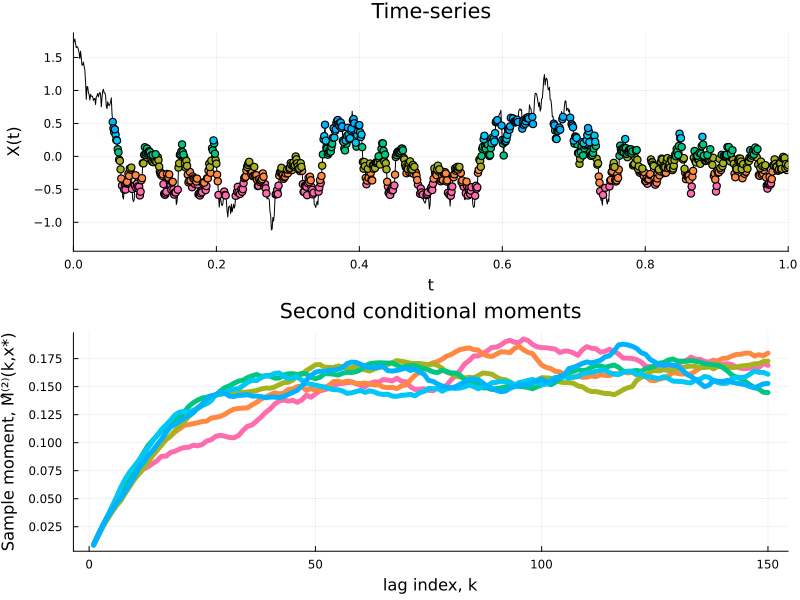

In [19]:
color_range = range(
    LCHab(70,70,0), 
    stop=LCHab(70,70,270), 
    length=size(M2,2)
)
in_bin(i) = broadcast(
    X->kernel((X-x_eval_points[i])/bandwidth) != 0.0,
    Xₜ
)

p_timeseries = plot(t,Xₜ,c=:black,xlim=(0,1),label="")
for i in 1:length(x_eval_points)
    scatter!(
        t[in_bin(i)],
        Xₜ[in_bin(i)],
        c=color_range[i],
        xlabel="t",ylabel="X(t)",title="Time-series",
        label="",
    )
end

p_moment = plot()
for i in 1:size(M2,2)
    plot!(
        i_lags,
        M2[:,i],
        linewidth=5,
        c=color_range[i],
        xlabel="lag index, k",ylabel="Sample moment, M̂⁽²⁾(k,x*)",
        title="Second conditional moments",
        label=""
    )
end

display(plot(p_timeseries,p_moment,layout=(2,1),size=(800,600)))

It is common to scale the conditional moments by $1/\tau$ when plotting

$$ M^{(n)}/\tau$$

In [20]:
Δt = t[2] - t[1]
M1τ = M1 ./ (Δt * i_lags)
M2τ = M2 ./ (Δt * i_lags);

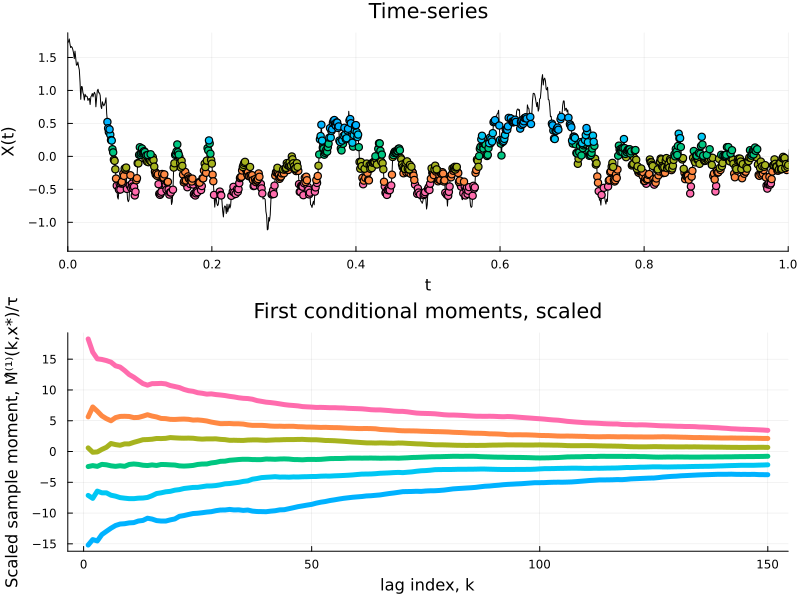

In [21]:
color_range = range(
    LCHab(70,70,0), 
    stop=LCHab(70,70,270), 
    length=size(M1τ,2)
)
in_bin(i) = broadcast(
    X->kernel((X-x_eval_points[i])/bandwidth) != 0.0,
    Xₜ
)

p_timeseries = plot(t,Xₜ,c=:black,xlim=(0,1),label="")
for i in 1:length(x_eval_points)
    scatter!(
        t[in_bin(i)],
        Xₜ[in_bin(i)],
        c=color_range[i],
        xlabel="t",ylabel="X(t)",title="Time-series",
        label="",
    )
end

p_moment = plot()
for i in 1:size(M1,2)
    plot!(
        i_lags,
        M1τ[:,i],
        linewidth=5,
        c=color_range[i],
        xlabel="lag index, k",ylabel="Scaled sample moment, M̂⁽¹⁾(k,x*)/τ",
        title="First conditional moments, scaled",
        label=""
    )
end

display(plot(p_timeseries,p_moment,layout=(2,1),size=(800,600)))

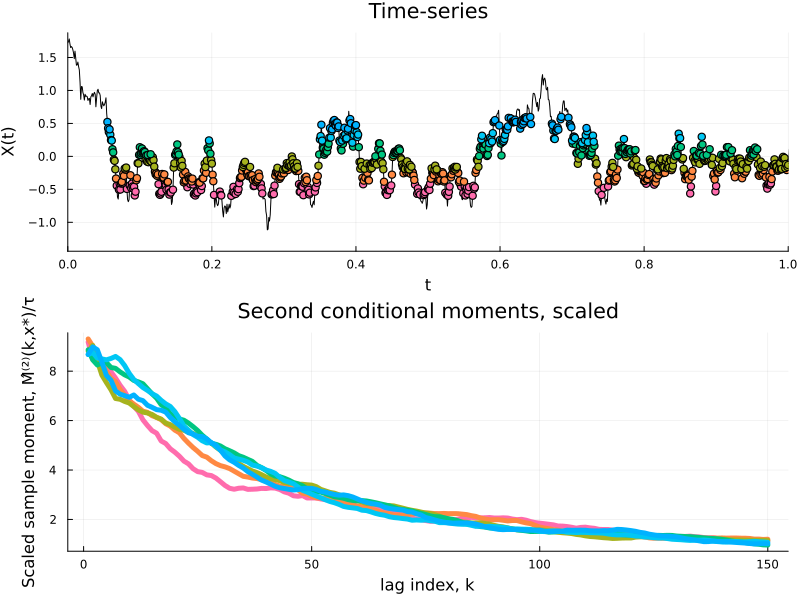

In [22]:
color_range = range(
    LCHab(70,70,0), 
    stop=LCHab(70,70,270), 
    length=size(M2τ,2)
)
in_bin(i) = broadcast(
    X->kernel((X-x_eval_points[i])/bandwidth) != 0.0,
    Xₜ
)

p_timeseries = plot(t,Xₜ,c=:black,xlim=(0,1),label="")
for i in 1:length(x_eval_points)
    scatter!(
        t[in_bin(i)],
        Xₜ[in_bin(i)],
        c=color_range[i],
        xlabel="t",ylabel="X(t)",title="Time-series",
        label="",
    )
end

p_moment = plot()
for i in 1:size(M2,2)
    plot!(
        i_lags,
        M2τ[:,i],
        linewidth=5,
        c=color_range[i],
        xlabel="lag index, k",ylabel="Scaled sample moment, M̂⁽²⁾(k,x*)/τ",
        title="Second conditional moments, scaled",
        label=""
    )
end

display(plot(p_timeseries,p_moment,layout=(2,1),size=(800,600)))

### Visualizing moments

In [23]:
function momentX_plot(MX,zlabel,zlim,title,c,clims,camera)
    p = wireframe(
        x_eval_points[:],
        i_lags[:],
        MX,
        zlim=zlim,
        xlabel="x", ylabel="τ", zlabel=zlabel, 
        title=title, 
        camera=camera
    )
    surface!(
        p,
        x_eval_points[:],
        i_lags[:],
        MX,
        alpha=0.9, # legend=:none,
        c=c,
        clims=clims
    )
    return p
end
moment1_plot(camera) = 
    momentX_plot(
        M1τ,
        "M⁽¹⁾/τ",
        (-Inf,Inf),
        "Scaled first moments",
        :balance,
        broadcast(x->(-x,x), maximum(abs.(M1τ))),
        camera
)
moment2_plot(camera) = 
    momentX_plot(
        M2τ,
        "M⁽²⁾/τ",
        (0,Inf),
        "Scaled second moments",
        :amp,
        (0,maximum(M2τ)),
        camera
)

moment2_plot (generic function with 1 method)

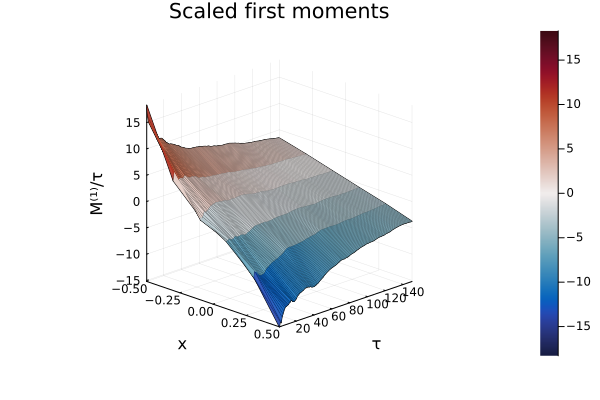

In [24]:
moment1_plot((45,20))

In [25]:
# Uncomment to make animation

#@gif for i in reverse(0:360)
#    moment1_plot((i,20))
#end every 1

## Why are moments useful?

They can be used to estimate drift and diffusion functions.

Suppose you assume that your time-series data was generated by a process of the form

$$ \frac{dX}{dt} = f(X) + g(X)\eta(t) $$

where $\eta(t)$ is *white noise*.

Then it can be shown that

$$ \hat{f}(x) = \lim_{\tau\rightarrow 0} \frac{1}{\tau}M^{(1)}(\tau,x), $$

$$ \hat{g}(x) = \sqrt{\lim_{\tau\rightarrow 0} \frac{1}{\tau}M^{(2)}(\tau,x)} $$

In [26]:
f_est = M1τ[2,:]
g_est = sqrt.(M2τ[1,:]);

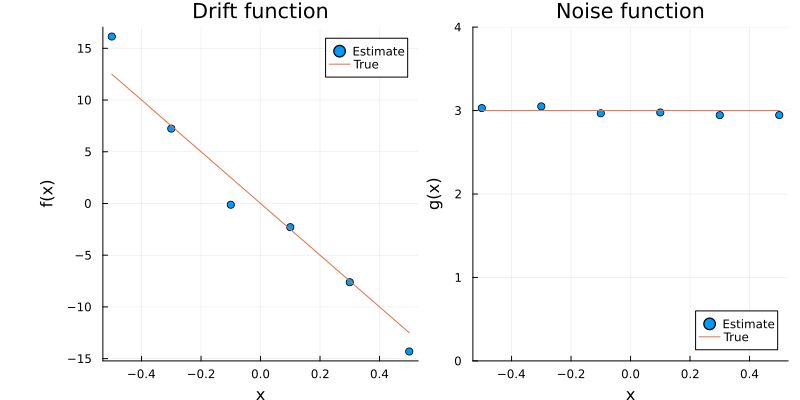

In [27]:
p1 = scatter(x_eval_points,f_est,
    label="Estimate",title="Drift function",
    xlabel="x",ylabel="f(x)",
    left_margin = 12mm
)
plot!((x)->-25.0*x,label="True")

p2 = scatter(x_eval_points,g_est,
    label="Estimate",title="Noise function",
    xlabel="x",ylabel="g(x)"
)
plot!((x)->3,label="True")
plot!(ylim=(0,4))

display(plot(p1,p2,layout=(1,2),size=(800,400)))

Even in the case of non-white noise, measurement errors, correlated noise, etc, it has been shown that conditional moments can be used to gather information about the original drift and diffusion functions (e.g., Tabar, 2019).



# Equations summary 

|   | <div style="width:290px">Autocorrelation</div> | <div style="width:350px">Conditional moment</div> |
| - | - | - |
| Definition | $\operatorname {R}_{XX}(t_{1},t_{2})=\operatorname {E} \big[X_{t_{1}}{ {X}}_{t_{2}}\big]$ | ${M}^{(n)}(\tau,x,t)=\int_{-\infty}^{\infty}(x^\prime - x)^nP(x^\prime,t+\tau | x,t
) dx^\prime$ |
| Wide-sense stationary | ${R}_{XX}(\tau )=\operatorname {E} \big[X_{t+\tau}X_{t}\big]$ | ${M}^{(n)}(\tau,x)=\int_{-\infty}^{\infty}(x^\prime - x)^nP(x^\prime,t+\tau | x,t
) dx^\prime$ |
|  |  | ${M}^{(n)}(\tau,x)=\operatorname {E} \left[\left(X(t+\tau) - X(t)\right)^n|X(t)=x\right]$|
| Assume ergodic | $R_{XX}(\tau )=\int _{-\infty }^{\infty }X(t+\tau ){ {X(t)}}\,{\rm {d}}t$ | ${M}^{(n)}(\tau,x)=\int_{-\infty}^{\infty}(X(t+\tau) - X(t))^n\cdot I(X(t)=x) dt$|
| Sample estimation | ${\hat {R}}(k)={\frac {1}{(N-k)}}\sum _{i=1}^{N-k}X_{i}X_{i+k}$ | $\hat{M}^{(n)}(k,x^*)=\frac{\sum _{i=1}^{N-k}I(x_-<X_i<x_+)\left(X_{i+k} - X_i\right)^n}{\sum _{i=1}^{N-k}I(x_-<X_i<x_+)}$ |

# References

Siegert, S., Friedrich, R., & Peinke, J. (1998). Analysis of data sets of stochastic systems. Physics Letters A, 243(5-6), 275-280.

Gardiner, C. W. (1985). Handbook of stochastic methods (Vol. 3, pp. 2-20). Berlin: springer.

Tabar, R. (2019). Analysis and data-based reconstruction of complex nonlinear dynamical systems (Vol. 730). Berlin/Heidelberg, Germany: Springer International Publishing.